In [2]:
import pandas as pd
import numpy as np

In [3]:
import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight')
plt.style.use('seaborn-paper')
# plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams.update({'figure.autolayout': True})

In [4]:
def data_labels(dataset):
    return (dataset[dataset.columns[1:]].values, dataset[dataset.columns[0]])

In [5]:
df_train = pd.read_csv("../data/fashion-mnist_train.csv")
df_test = pd.read_csv("../data/fashion-mnist_test.csv")
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
label_count = 10
label_descriptions = ["T-shirt/top", "Trouser","Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
train_data, train_labels = data_labels(df_train)

In [6]:
print(sum(labels))

45


[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


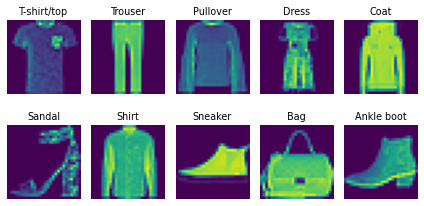

In [7]:
# Check label distribution
print(df_train["label"].value_counts(normalize=True).to_numpy())
print(df_test["label"].value_counts(normalize=True).to_numpy())
# Visualize
examples = df_train.groupby("label").sample(1)
fig = plt.figure()
for i in range(0,10):
    fig.add_subplot(2, 5, i+1)
    example = examples.iloc[i].to_numpy()
    plt.imshow(example[1:].reshape(28,28))
    plt.axis('off')
    plt.title(label_descriptions[example[0]])
plt.savefig('graphs/images',bbox_inches='tight')

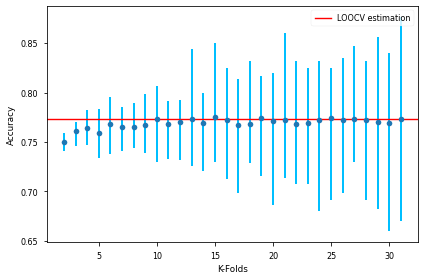

In [8]:
df = pd.read_csv('res/KFold_K_kNN.csv').groupby('K')
means = df['accuracy'].mean().to_numpy()
mins = means - df['accuracy'].min().to_numpy()
maxs = df['accuracy'].max().to_numpy() - means
Ks = list(df['K'].unique())
ideal = pd.read_csv('res/LOOCV_kNN.csv')['accuracy'].mean()
plt.errorbar(Ks, means, yerr=[mins, maxs], fmt='o', ecolor='deepskyblue', elinewidth=2)
plt.axhline(y=ideal, color='r', label='LOOCV estimation')
plt.legend()
# plt.title("kNN mean accuracy for different values of K")
plt.xlabel('K-Folds')
plt.ylabel('Accuracy')
plt.savefig('graphs/KFold_kNN',bbox_inches='tight')

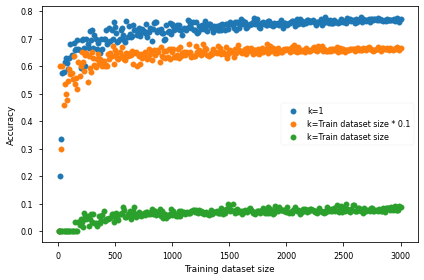

In [9]:
fig = plt.figure()
ax = fig.add_subplot()
df = pd.read_csv("res/kNN_k_fixed.csv").groupby('size')
accuracies = df['accuracy'].mean().to_numpy()
sizes = df['size'].unique()
ax.scatter(x=sizes ,y=accuracies, label="k=1")
df = pd.read_csv("res/kNN_k_proportional.csv").groupby('size')
accuracies = df['accuracy'].mean().to_numpy()
sizes = df['size'].unique()
ks = df['k'].unique()
ax.scatter(x=sizes, y=accuracies, label="k=Train dataset size * 0.1")
df = pd.read_csv("res/kNN_k_size.csv").groupby('size')
accuracies = df['accuracy'].mean().to_numpy()
sizes = df['size'].unique()
ks = df['k'].unique()
ax.scatter(x=sizes, y=accuracies, label="k=Train dataset size")
plt.xlabel("Training dataset size")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('graphs/kNN_size',bbox_inches='tight')

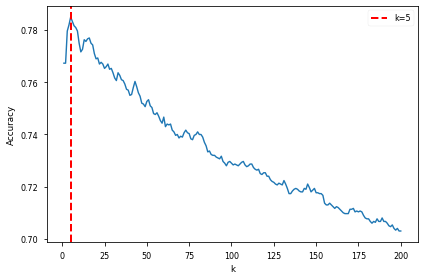

In [10]:
df = pd.read_csv("res/kNN_k_linspace.csv").groupby('k')
accuracies = df['accuracy'].mean().to_numpy()
ks = df['k'].unique()
maxk = ks[accuracies.argmax()+1]
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(ks, accuracies)
ax.axvline(maxk, color='r', ls='--', label='k='+str(int(maxk[0])), linewidth=2)
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('graphs/kNN_k')

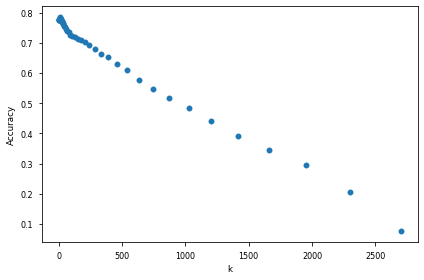

In [11]:
df = pd.read_csv("res/kNN_k_logspace.csv").groupby('k')
accuracies = df['accuracy'].mean().to_numpy()
ks = df['k'].unique()
maxk = ks[accuracies.argmax()+1]
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(ks, accuracies)
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.savefig('graphs/kNN_k_log')

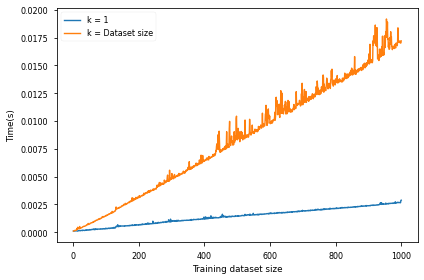

In [12]:
df_kfixed = pd.read_csv("res/kNN_perf_k_fixed.csv")
df_kprop = pd.read_csv("res/kNN_perf_k_proportional.csv")
plt.plot(df_kfixed['size'], df_kfixed['time'], label='k = 1')
plt.plot(df_kprop['size'], df_kprop['time'], label='k = Dataset size')
plt.xlabel("Training dataset size")
plt.ylabel("Time(s)")
plt.legend()
plt.savefig('graphs/kNN_perf',bbox_inches='tight')

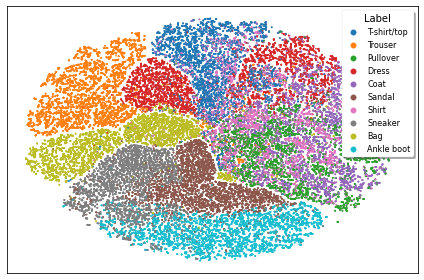

In [13]:
df = pd.read_csv("res/tsne_n2.csv")
fig = plt.figure()
ax = plt.subplot()
ax.tick_params(axis='both', label1On=False, tick1On=False)
scatter = ax.scatter(df['x'], df['y'], c=train_labels, s=2, cmap='tab10')
handles, _ = scatter.legend_elements(prop="colors", alpha=1)
label_legend = ax.legend(handles, label_descriptions, loc="upper right", title="Label", fancybox=True, shadow=True, bbox_to_anchor=(1,1))
plt.savefig('graphs/tsne',bbox_inches='tight')

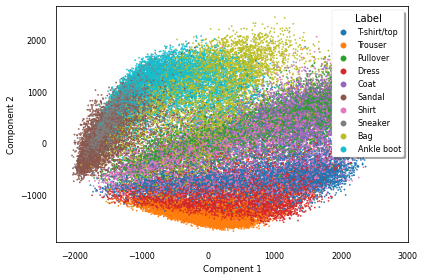

In [14]:
df = pd.read_csv("res/PCA_alpha2.csv")
fig = plt.figure()
ax = plt.subplot()
ax.tick_params(axis='both', tick1On=False)
scatter = ax.scatter(df['x'], df['y'], c=train_labels, s=2, cmap='tab10')
handles, _ = scatter.legend_elements(prop="colors", alpha=1)
label_legend = ax.legend(handles, label_descriptions, loc="upper right", title="Label", fancybox=True, shadow=True, bbox_to_anchor=(1, 1))
plt.xlabel('Component 1');
plt.ylabel('Component 2');
plt.savefig('graphs/PCA_r2',bbox_inches='tight')

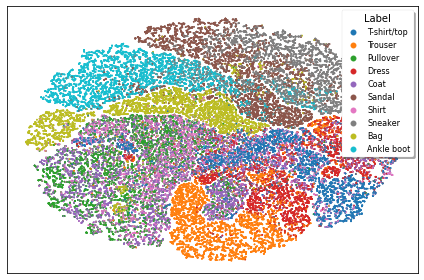

In [15]:
df = pd.read_csv("res/tsne_PCA_alpha5.csv")
fig = plt.figure()
ax = plt.subplot()
ax.tick_params(axis='both', label1On=False, tick1On=False)
scatter = ax.scatter(df['x'], df['y'], c=train_labels, s=2, cmap='tab10')
handles, _ = scatter.legend_elements(prop="colors", alpha=1)
label_legend = ax.legend(handles, label_descriptions, loc="upper right", title="Label", fancybox=True, shadow=True, bbox_to_anchor=(1,1))
plt.savefig('graphs/tsne_PCA_5',bbox_inches='tight')

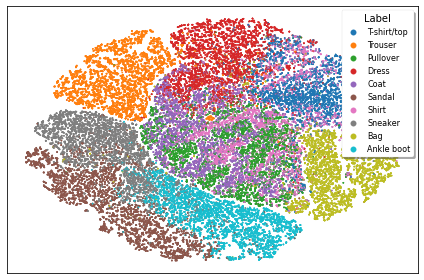

In [16]:
df = pd.read_csv("res/tsne_PCA_50.csv")
fig = plt.figure()
ax = plt.subplot()
ax.tick_params(axis='both', label1On=False, tick1On=False)
scatter = ax.scatter(df['x'], df['y'], c=train_labels, s=2, cmap='tab10')
handles, _ = scatter.legend_elements(prop="colors", alpha=1)
label_legend = ax.legend(handles, label_descriptions, loc="upper right", title="Label", fancybox=True, shadow=True, bbox_to_anchor=(1,1))
plt.savefig('graphs/tsne_PCA_50',bbox_inches='tight')

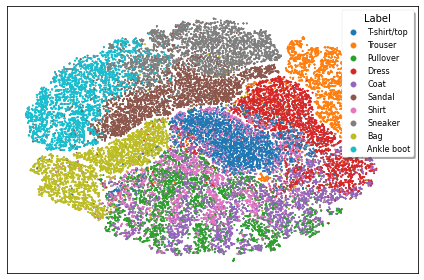

In [17]:
df = pd.read_csv("res/tsne_PCA_100.csv")
fig = plt.figure()
ax = plt.subplot()
ax.tick_params(axis='both', label1On=False, tick1On=False)
scatter = ax.scatter(df['x'], df['y'], c=train_labels, s=2, cmap='tab10')
handles, _ = scatter.legend_elements(prop="colors", alpha=1)
label_legend = ax.legend(handles, label_descriptions, loc="upper right", title="Label", fancybox=True, shadow=True, bbox_to_anchor=(1,1))
plt.savefig('graphs/tsne_PCA_100',bbox_inches='tight')

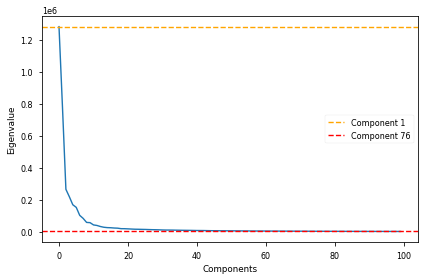

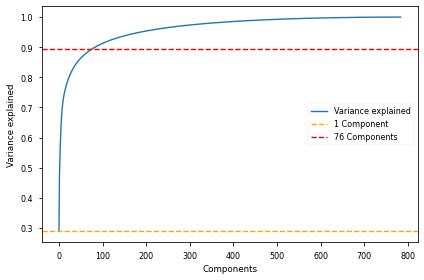

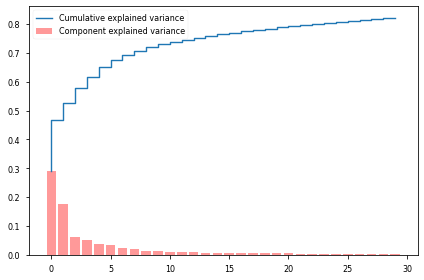

In [18]:
values = pd.read_csv("res/PCA_component_values.csv")['values']
plt.plot(values[0:100])
plt.axhline(y=values[0], color='orange', linestyle='--', label='Component 1')
plt.axhline(y=values[76], color='r', linestyle='--', label='Component 76')
plt.xlabel("Components")
plt.ylabel("Eigenvalue")
plt.legend()
plt.savefig('graphs/PCA_scree',bbox_inches='tight')
plt.show()

ratios = values/sum(values)
var_accum = ratios.cumsum()
plt.plot(var_accum, label='Variance explained')
plt.axhline(y=var_accum[0], color='orange', linestyle='--', label='1 Component')
plt.axhline(y=var_accum[76], color='r', linestyle='--', label='76 Components')
plt.legend()
plt.xlabel("Components")
plt.ylabel("Variance explained")
plt.savefig('graphs/PCA_cev',bbox_inches='tight')
plt.show()

var_accum = ratios.cumsum()
plt.bar(range(0,30,1), ratios[0:30], alpha=0.4, color='red', label='Component explained variance')
plt.step(range(0,30,1), var_accum[0:30], label='Cumulative explained variance')
plt.legend()
plt.savefig('graphs/PCA_ev_ac',bbox_inches='tight')

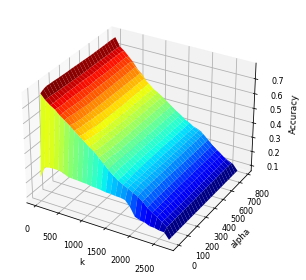

In [19]:
df = pd.read_csv("res/kNN_PCA_k_alpha_variable.csv")
alphas = df['alpha'].unique().astype(int)
ks = df['k'].unique().astype(int)
accs = np.empty((len(alphas),len(ks)),dtype=float)
for i in range(len(alphas)):
    alpha = alphas[i]
    df_alpha = df[df['alpha']==alpha]
    for j in range(len(ks)):
        k = ks[j]
        accs[i][j] = df_alpha[df_alpha['k']==k]['accuracy'].mean()
a_, k_ = np.meshgrid(ks, alphas)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(a_, k_, accs, cmap='jet', shade=True)
ax.set_ylabel('alpha')
ax.set_xlabel('k')
ax.set_zlabel('Accuracy')
plt.savefig('graphs/kNN_PCA_3d',bbox_inches='tight')

(37, 5)


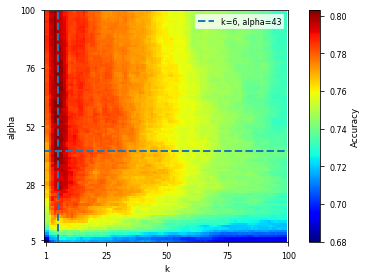

In [20]:
df = pd.read_csv("res/kNN_PCA_k_alpha_variable_small.csv")
alphas = df['alpha'].unique()
ks = df['k'].unique()
accs = np.empty((len(alphas)-5,len(ks)),dtype=float)
for i in range(len(alphas)-5):
    alpha = alphas[i+5]
    df_alpha = df[df['alpha']==alpha]
    for j in range(len(ks)):
        k = ks[j]
        accs[i][j] = df_alpha[df_alpha['k']==k]['accuracy'].mean()
f_max_index = accs.argmax()
max_index = np.unravel_index(f_max_index, accs.shape)
print(max_index)

fig = plt.figure()
ax = fig.add_subplot()
ax.imshow(accs, cmap='jet', origin='lower', interpolation='none', resample=False)
cbar = plt.colorbar(ax.get_images()[0])
cbar.set_label('Accuracy')
ax.set_xticks(np.linspace(0,100,5, dtype=int))
ax.set_xticklabels(np.linspace(1,100,5, dtype=int))
ax.set_yticks(np.linspace(0,95,5, dtype=int))
ax.set_yticklabels(np.linspace(5,100,5, dtype=int))
plt.axvline(max_index[1], linewidth=2, ls='--', label='k=6, alpha=43')
plt.axhline(max_index[0], linewidth=2, ls='--')
plt.legend()
plt.xlabel('k')
plt.ylabel('alpha')
plt.savefig('graphs/kNN_PCA_heat',bbox_inches='tight')

kNN
- kNN fit/predict time: 460.510

kNN + PCA
- PCA fit/transform time: 4.740s
- kNN fit/predict time: 21.232s
- Total time: 25.972s

kNN k=6 accuracy: 0.860
kNN+PCA k=6 alpha=43 accuracy: 0.859


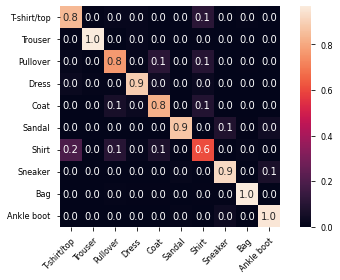

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
df = pd.read_csv("res/kNN_k6.csv")
print("kNN k=6 accuracy: %.3f" % accuracy_score(df['true_labels'], df['pred_labels']))
df = pd.read_csv("res/kNN_PCA_k6_alpha43.csv")
true_labels = df['true_labels']
pred_labels = df['pred_labels']
cf_matrix = confusion_matrix(true_labels, pred_labels, normalize='true')
print("kNN+PCA k=6 alpha=43 accuracy: %.3f" % accuracy_score(true_labels, pred_labels))
# Plot
ax = sns.heatmap(cf_matrix, annot=True, fmt='.1f', square=True)
ax.set_xticks(ax.get_xticks(), labels=label_descriptions)
ax.set_yticks(ax.get_yticks(), labels=label_descriptions)
# ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor");
plt.setp(ax.get_yticklabels(), rotation=0, ha="right",rotation_mode="anchor");
